In [56]:
import torch
from torch import nn 
from torch.utils.data import DataLoader
from torchvision import datasets 
from torchvision.transforms import ToTensor

In [57]:
training_data = datasets.FashionMNIST(
    root='data', train=True, download=True, transform=ToTensor()
)
testing_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [58]:
train_dl= DataLoader(training_data, batch_size=54)
test_dl = DataLoader(testing_data, batch_size=54)

In [59]:
for X, y in test_dl:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([54, 1, 28, 28])
Shape of y: torch.Size([54]) torch.int64


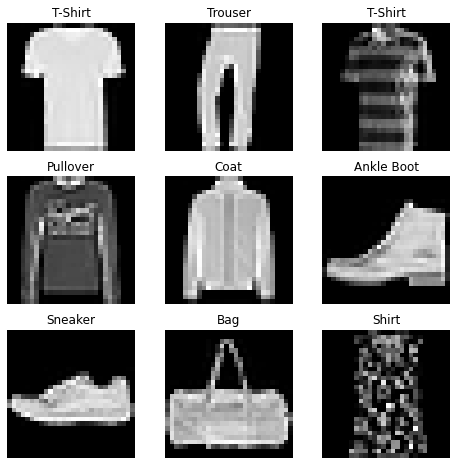

In [60]:
import matplotlib.pyplot as plt
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [61]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [62]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [63]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [64]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [65]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, model, loss_fn, optimizer)
    test(test_dl, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302829  [    0/60000]
loss: 2.286823  [ 5400/60000]
loss: 2.261719  [10800/60000]
loss: 2.256788  [16200/60000]
loss: 2.226158  [21600/60000]
loss: 2.228911  [27000/60000]
loss: 2.229530  [32400/60000]
loss: 2.184693  [37800/60000]
loss: 2.179415  [43200/60000]
loss: 2.184713  [48600/60000]
loss: 2.135581  [54000/60000]
loss: 2.100572  [59400/60000]
Test Error: 
 Accuracy: 45.6%, Avg loss: 2.115581 

Epoch 2
-------------------------------
loss: 2.111768  [    0/60000]
loss: 2.107103  [ 5400/60000]
loss: 2.035954  [10800/60000]
loss: 2.030518  [16200/60000]
loss: 1.955340  [21600/60000]
loss: 1.966478  [27000/60000]
loss: 1.976099  [32400/60000]
loss: 1.890997  [37800/60000]
loss: 1.878446  [43200/60000]
loss: 1.914117  [48600/60000]
loss: 1.793263  [54000/60000]
loss: 1.743330  [59400/60000]
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.754413 

Epoch 3
-------------------------------
loss: 1.758081  [    0/60000]
loss: 1.749982  [ 5400/600

We shall now start with PyTorch's tensor. What are tensors mathematically? Tensors are objects that define a "multilinear" relationship between algebraic objects and vector spaces.

Tensors are similar to ndarrays in numpy except for the fact that:
1. tensors can run on GPU and other accelerators
2. tensors are optimized for automatic differentiation 

In [66]:
import numpy as np
import torch

There are four ways to initialize a tensor:
1.   from data
2.   from numpy array
3.   form another tensor
4.   with some constant value like 0 or 1 or random numbers

In [67]:
#Through 1st method
x=[[1,2],[3,4]]
data=torch.tensor(x)
data

tensor([[1, 2],
        [3, 4]])

In [68]:
#Through 2nd method
y=np.array([[1,2],[3,4]])
data_np=torch.from_numpy(y)
data_np

tensor([[1, 2],
        [3, 4]])

In [69]:
#Through 3rd method
z=torch.ones_like(data)
w=torch.rand_like(data, dtype=torch.float)
print(z)
print(w)
#When initializing a tensor from a tensor, we use a tensor and then the functions like ones_like, zeros_like, rand_like to add to it while preserving the shape of data which was (2,2)

tensor([[1, 1],
        [1, 1]])
tensor([[0.3599, 0.8769],
        [0.0321, 0.6239]])


In [70]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
#There is a difference between ones_like,rand_like and ones, rand, which is the fact that ones_like preserve shape of data and does not explicitly take shape input but wants
#a tensor as an input while torch.ones wants a shape as an input.

The attributes of a tensor are its shape, data type and the device that it is stored on. Let us talk about our tensor data.

In [71]:
print(data.shape)
print(data.dtype)
print(data.device)

torch.Size([2, 2])
torch.int64
cpu


We can also join two or more tensors along a given dimension. If dimension is 1, then we join it by concatenating them in the column and if dimension is 0 then it is through rows.

In [72]:
t1=torch.cat([data,data_np],dim=1)
t1

tensor([[1, 2, 1, 2],
        [3, 4, 3, 4]])

In [73]:
t2=torch.cat([data,data_np], dim=0)
t2

tensor([[1, 2],
        [3, 4],
        [1, 2],
        [3, 4]])

In [74]:
t3=torch.cat([data,data_np],dim=3) #there is error since there are only two dimensions - row-wise or column-wise, we cannot concatenate along any third dimension.

IndexError: ignored

Let us now try the arithmetic operations that we know for numpy ndarrays on tensors.

In [75]:
data_t=data.T #this returns transpose of data in pytorch
data_t 

tensor([[1, 3],
        [2, 4]])

In [76]:
a=np.array([[1,2],[5,4]])
b=a.T #this is the same operation in numpy

In [77]:
print(data @ data_t)
print(a @ b) 
#THis is for matrix multiplication. We can also use matmul
print(data.matmul(data_t))
print(np.matmul(a,b))
#In numpy also we have matmul but it works differently in terms of syntax.
#@ is the semantics for matmul

tensor([[ 5, 11],
        [11, 25]])
[[ 5 13]
 [13 41]]
tensor([[ 5, 11],
        [11, 25]])
[[ 5 13]
 [13 41]]


In [78]:
#Let us now try component wise multiplication 
data*data.T

tensor([[ 1,  6],
        [ 6, 16]])

In [79]:
#Broadcasting also happens in tensors. For example:
u=[3]
u_tensor=torch.tensor(u)
print(u_tensor)
print(data+u_tensor)
print(data*u_tensor)

tensor([3])
tensor([[4, 5],
        [6, 7]])
tensor([[ 3,  6],
        [ 9, 12]])


##Transforms
Data does not always come in the shape that is acceptable for training a machine learning algorithm, so we can perform some manipulations on this data and make it of the acceptable form. These manipulations are called transformations. All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels. For former we use To_Tensor() and for latter we use lambda functions when we want to define a function to turn the integer into a one-hot encoded tensor.

In [80]:
target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
#the first part creates zero tensor of size 10. The second part scatter_ assigns value 1 to all the index given by label y

NameError: ignored

##Build the Neural Network

Neural networks contain layers that perform operation on data. `torch.nn` provides all the building blocks you need to build a custom neural networks. All models are subclasses of `nn.Module`. Even a neural network is a module containing other layers/modules and is contained in this module. It is the base class for all neural network models. 

In [81]:
#We start by getting the right device for training
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [82]:
#We now define our neural network by subclassing `nn.Module`
import torch.nn as nn
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
          nn.Linear(28*28, 512),
          nn.ReLU(),
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512, 10),
      )
    
  def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [83]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model’s forward, along with some background operations. Do not call model.forward() directly!

In [84]:
X=torch.rand(1,28,28, device=device)
logits=model(X)
# We get the prediction probabilities by passing it through an instance of the nn.Softmax module.
predict_prob=nn.Softmax(dim=1)(logits)
y_pred=predict_prob.argmax(1)
y_pred

tensor([4], device='cuda:0')

##Hyperparameters and Optimization
Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates (read more about hyperparameter tuning)

We define the following hyperparameters for training:

Number of Epochs - the number times to iterate over the dataset

Batch Size - the number of data samples propagated through the network before the parameters are updated

Learning Rate - how much to update models parameters at each batch/epoch. 

Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

Once we set our hyperparameters, 

we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:
The Train Loop - iterate over the training dataset and try to converge to optimal parameters.
The Validation/Test Loop - iterate over the test dataset to check if model performance is improving.

#Loss Function
Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks, and nn.NLLLoss (Negative Log Likelihood) for classification. nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss.

#Optimization algorithms 

how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the optimizer object. 

There are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

In the code below, we run a full implementation of a neural network in PyTorch. We define `train_loop` that loops over our optimization code, and `test_loop` that evaluates the model’s performance against our test data.

In [85]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(test_loss)
    print(correct)

In [86]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dl, model, loss_fn, optimizer)
    test_loop(test_dl, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: ignored